In [110]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import matplotlib.gridspec as gridspec
import shutil

#from evaluation_functions import *
from importlib import reload
from functions_ import *
from plotting import *

In [209]:
## reload the evaluation functions
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *



In [200]:
base_dir = os.getcwd()
R5_Pool_seq = "GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTC"

catch_left = "" #"ACACTCTTTCCCTACACGACGCTCTTCCGATCT" ## Adapter fwd
catch_right = "" #"GACTGGAGTTCAGACGTGTGCTCTTCCGATCT"

Barcodes = {"BC1_fwd": "AAGG",
            "BC1_rev": "ATCA",
            "BC2_fwd": "AGTC",
            "BC2_rev": "GCCG",
            "BC3_fwd": "AGGA",
            "BC3_rev": "AATT",
            "BC4_fwd": "GCGA",
            "BC4_rev": "TGGT",
            "BC5_fwd": "CCAT",
            "BC5_rev": "GACC",
            "BC6_fwd": "CTAG",
            "BC6_rev": "CCAG",
            }
            

S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC"
S1_rev_primer = "TCGGCCAGTTCAGCCATTCA"
S1_rev_primer_compseq = dna_rev_comp(S1_rev_primer)
S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG"
S2_rev_primer = "TAGCACGGTCAGTCTCTGGC"
S2_rev_primer_compseq = dna_rev_comp(S2_rev_primer)
S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC"
S3_rev_primer = "ACATGCTGCGCCACGCTC"
S3_rev_primer_compseq = dna_rev_comp(S3_rev_primer)
S4_fwd_primer = "GATAACCGCGTGCGCGAA"
S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
S4_rev_primer_compseq = dna_rev_comp(S4_rev_primer)

Primer_seq = dict(
            S1_fwd = "GGCGCAACTATCGGTATCAAGC",
            S1_rev = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev = "ACATGCTGCGCCACGCTC",
            S4_fwd = "GATAACCGCGTGCGCGAA",
            S4_rev = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

Primer_out_of_triplets = {"S1_fwd": 2,
                     "S1_rev": 1, 
                     "S2_fwd": 2,
                     "S2_rev": 1,
                     "S3_fwd": 1,
                     "S3_rev": 2,
                     "S4_fwd": 0,
                     "S4_rev": 3} ##?



In [4]:
## add numbers of positions to the sequence
R5_Pool_AA = translate_dna2aa(R5_Pool_seq[2:])
AraC_AA_start_pos = 37
LOV2_AA_start_pos = 210
LOV2_AA_end_pos = 351# len 145
AraC_end_pos = 477 # len 124

AA_berfore_AraC_start = [R5_Pool_AA[i] for i in range(AraC_AA_start_pos)]
AA_AraC_part1 = [R5_Pool_AA[i]+str(i-AraC_AA_start_pos) for i in range(AraC_AA_start_pos,LOV2_AA_start_pos-2)]
AA_linker1 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_start_pos+2) for i in range(LOV2_AA_start_pos-2,LOV2_AA_start_pos)]
AA_Lov2 = [R5_Pool_AA[i]+str(404+i-LOV2_AA_start_pos) for i in range(LOV2_AA_start_pos,LOV2_AA_end_pos)]
AA_linker2 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_end_pos+2) for i in range(LOV2_AA_end_pos,LOV2_AA_end_pos+2)]
AA_AraC_part2 = [R5_Pool_AA[i]+str((LOV2_AA_start_pos-2-AraC_AA_start_pos)+i-(LOV2_AA_end_pos+2)) for i in range(LOV2_AA_end_pos+2,AraC_end_pos )]
AA_after_AraC = [R5_Pool_AA[i] for i in range(AraC_end_pos,len(R5_Pool_AA))]

R5_Pool_AA_annot = AA_berfore_AraC_start + AA_AraC_part1 + AA_linker1 + AA_Lov2 + AA_linker2 + AA_AraC_part2 + AA_after_AraC

# AraC analysis

In [190]:
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
variant1 ="MutS2S3_2"#"MutS2S3_2"#"S2S3alt3cyclesmut"
variant1_used_BCs = ["BC1", "BC2", "BC3"] 


variant2 ="NegPosS2S3_2" #"NegPosS2S3_2"#"S2S3alt3cyclesNegPos"
variant2_used_BCs = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"]

### for repeated seq of S2, S3, different primers were used:
Primer_seq["S2_fwd"] = "GCATTTTAGCGATCTGTTTGGCC"
Primer_seq["S3_fwd"] = "TTCTGGAATTTATTTCACTTGCAGCC"

Primer_out_of_triplets["S2_fwd"] = 1
Primer_out_of_triplets["S3_fwd"] = 0

ref_gene = R5_Pool_seq

catch_left = catch_left
catch_right = catch_right

Sections = ["S2", "S3"]

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections =Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids, filter_for_read_len=True, read_len_treshold= None)#(150, 150)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  filter_for_read_len=True, read_len_treshold= None) 

all_reads = {**{variant1+"_"+key : value for key, value in Mutagenesis_reads.items()},**{variant2+"_"+key : value for key, value in NegPosSelection_reads.items()}}

all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},**{variant2+"_"+key : value for key, value in NegPos_ids.items()}}

samples = ['S2S3alt3cyclesmut_BC1',
 'S2S3alt3cyclesNegPos_BC1',
 'S2S3alt3cyclesNegPos_BC2',
 'S2S3alt3cyclesmut_BC2',
 'S2S3alt3cyclesNegPos_BC3',
 'S2S3alt3cyclesNegPos_BC4',
 'S2S3alt3cyclesmut_BC3',
 'S2S3alt3cyclesNegPos_BC5',
 'S2S3alt3cyclesNegPos_BC6'] # use only R1 names 

samples = ['MutS2S3_2_BC1',
 'NegPosS2S3_2_BC1',
 'NegPosS2S3_2_BC2',
 'MutS2S3_2_BC2',
 'NegPosS2S3_2_BC3',
 'NegPosS2S3_2_BC4',
 'MutS2S3_2_BC3',
 'NegPosS2S3_2_BC5',
 'NegPosS2S3_2_BC6']

plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]

FigFolder = None


total reads 128250
BC1 S2 27200 reads
total forward reads before filtering 27200
total reverse reads before filtering 27200
total forward reads after filtering 23284
total reverse reads after filtering 22466
BC1 S3 22538 reads
total forward reads before filtering 22538
total reverse reads before filtering 22538
total forward reads after filtering 19094
total reverse reads after filtering 18942
BC2 S2 23136 reads
total forward reads before filtering 23136
total reverse reads before filtering 23136
total forward reads after filtering 19041
total reverse reads after filtering 18820
BC2 S3 32733 reads
total forward reads before filtering 32733
total reverse reads before filtering 32733
total forward reads after filtering 28524
total reverse reads after filtering 27672
BC3 S2 19271 reads
total forward reads before filtering 19271
total reverse reads before filtering 19271
total forward reads after filtering 15475
total reverse reads after filtering 15387
BC3 S3 22272 reads
total forward rea

In [210]:
### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
#remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',]
remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']


variant1 = "Cycle2Mutagenesis"
variant1_used_BCs = ["BC1"] #["BC1", "BC2"]

variant2 = "Cycle2NegPos"
variant2_used_BCs = ["BC1", "BC2"]#["BC1", "BC2", "BC3", "BC4"]

variant3 = "Mutagenesis"
variant3_used_BCs = ["BC1", "BC2"]

variant4 = "NegPosSelection"
variant4_used_BCs = ["BC1", "BC2", "BC3", "BC4"]

catch_left = catch_left
catch_right = catch_right

## variant1
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Cycle2Mutagenesis_reads, Cycle2Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= None)#(150, 150)


## variant2
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Cycle2NegPosSelection_reads, Cycle2NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,read_len_treshold= None)


## variant3
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant3, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant3_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,read_len_treshold= None)#(150, 150)


## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant4, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant4_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= None)


all_reads = {**{variant1+"_"+key : value for key, value in Cycle2Mutagenesis_reads.items()},
            **{variant2+"_"+key : value for key, value in Cycle2NegPosSelection_reads.items()}, 
            **{variant3+"_"+key : value for key, value in Mutagenesis_reads.items()},
            **{variant4+"_"+key : value for key, value in NegPosSelection_reads.items()}}

# all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},
#            **{variant2+"_"+key : value for key, value in NegPos_ids.items()}}

samples = ["Mutagenesis_BC1", "NegPosSelection_BC1", "NegPosSelection_BC2", "Cycle2Mutagenesis_BC1", "Cycle2NegPos_BC1", "Cycle2NegPos_BC2","Mutagenesis_BC2", "NegPosSelection_BC3", "NegPosSelection_BC4"]

plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]

Sections = ["S1", "S2", "S3", "S4"]


total reads 68823
BC1 S1 14308 reads
total forward reads before filtering 14308
total reverse reads before filtering 14308
total forward reads after filtering 11745
total reverse reads after filtering 12842
BC1 S2 16796 reads
total forward reads before filtering 16796
total reverse reads before filtering 16796
total forward reads after filtering 13778
total reverse reads after filtering 13461
BC1 S3 20355 reads
total forward reads before filtering 20355
total reverse reads before filtering 20355
total forward reads after filtering 16582
total reverse reads after filtering 16758
BC1 S4 21817 reads
total forward reads before filtering 21817
total reverse reads before filtering 21817
total forward reads after filtering 18969
total reverse reads after filtering 19413
total reads 62671
BC1 S1 7604 reads
total forward reads before filtering 7604
total reverse reads before filtering 7604
total forward reads after filtering 5367
total reverse reads after filtering 6078
BC1 S2 7793 reads
total 

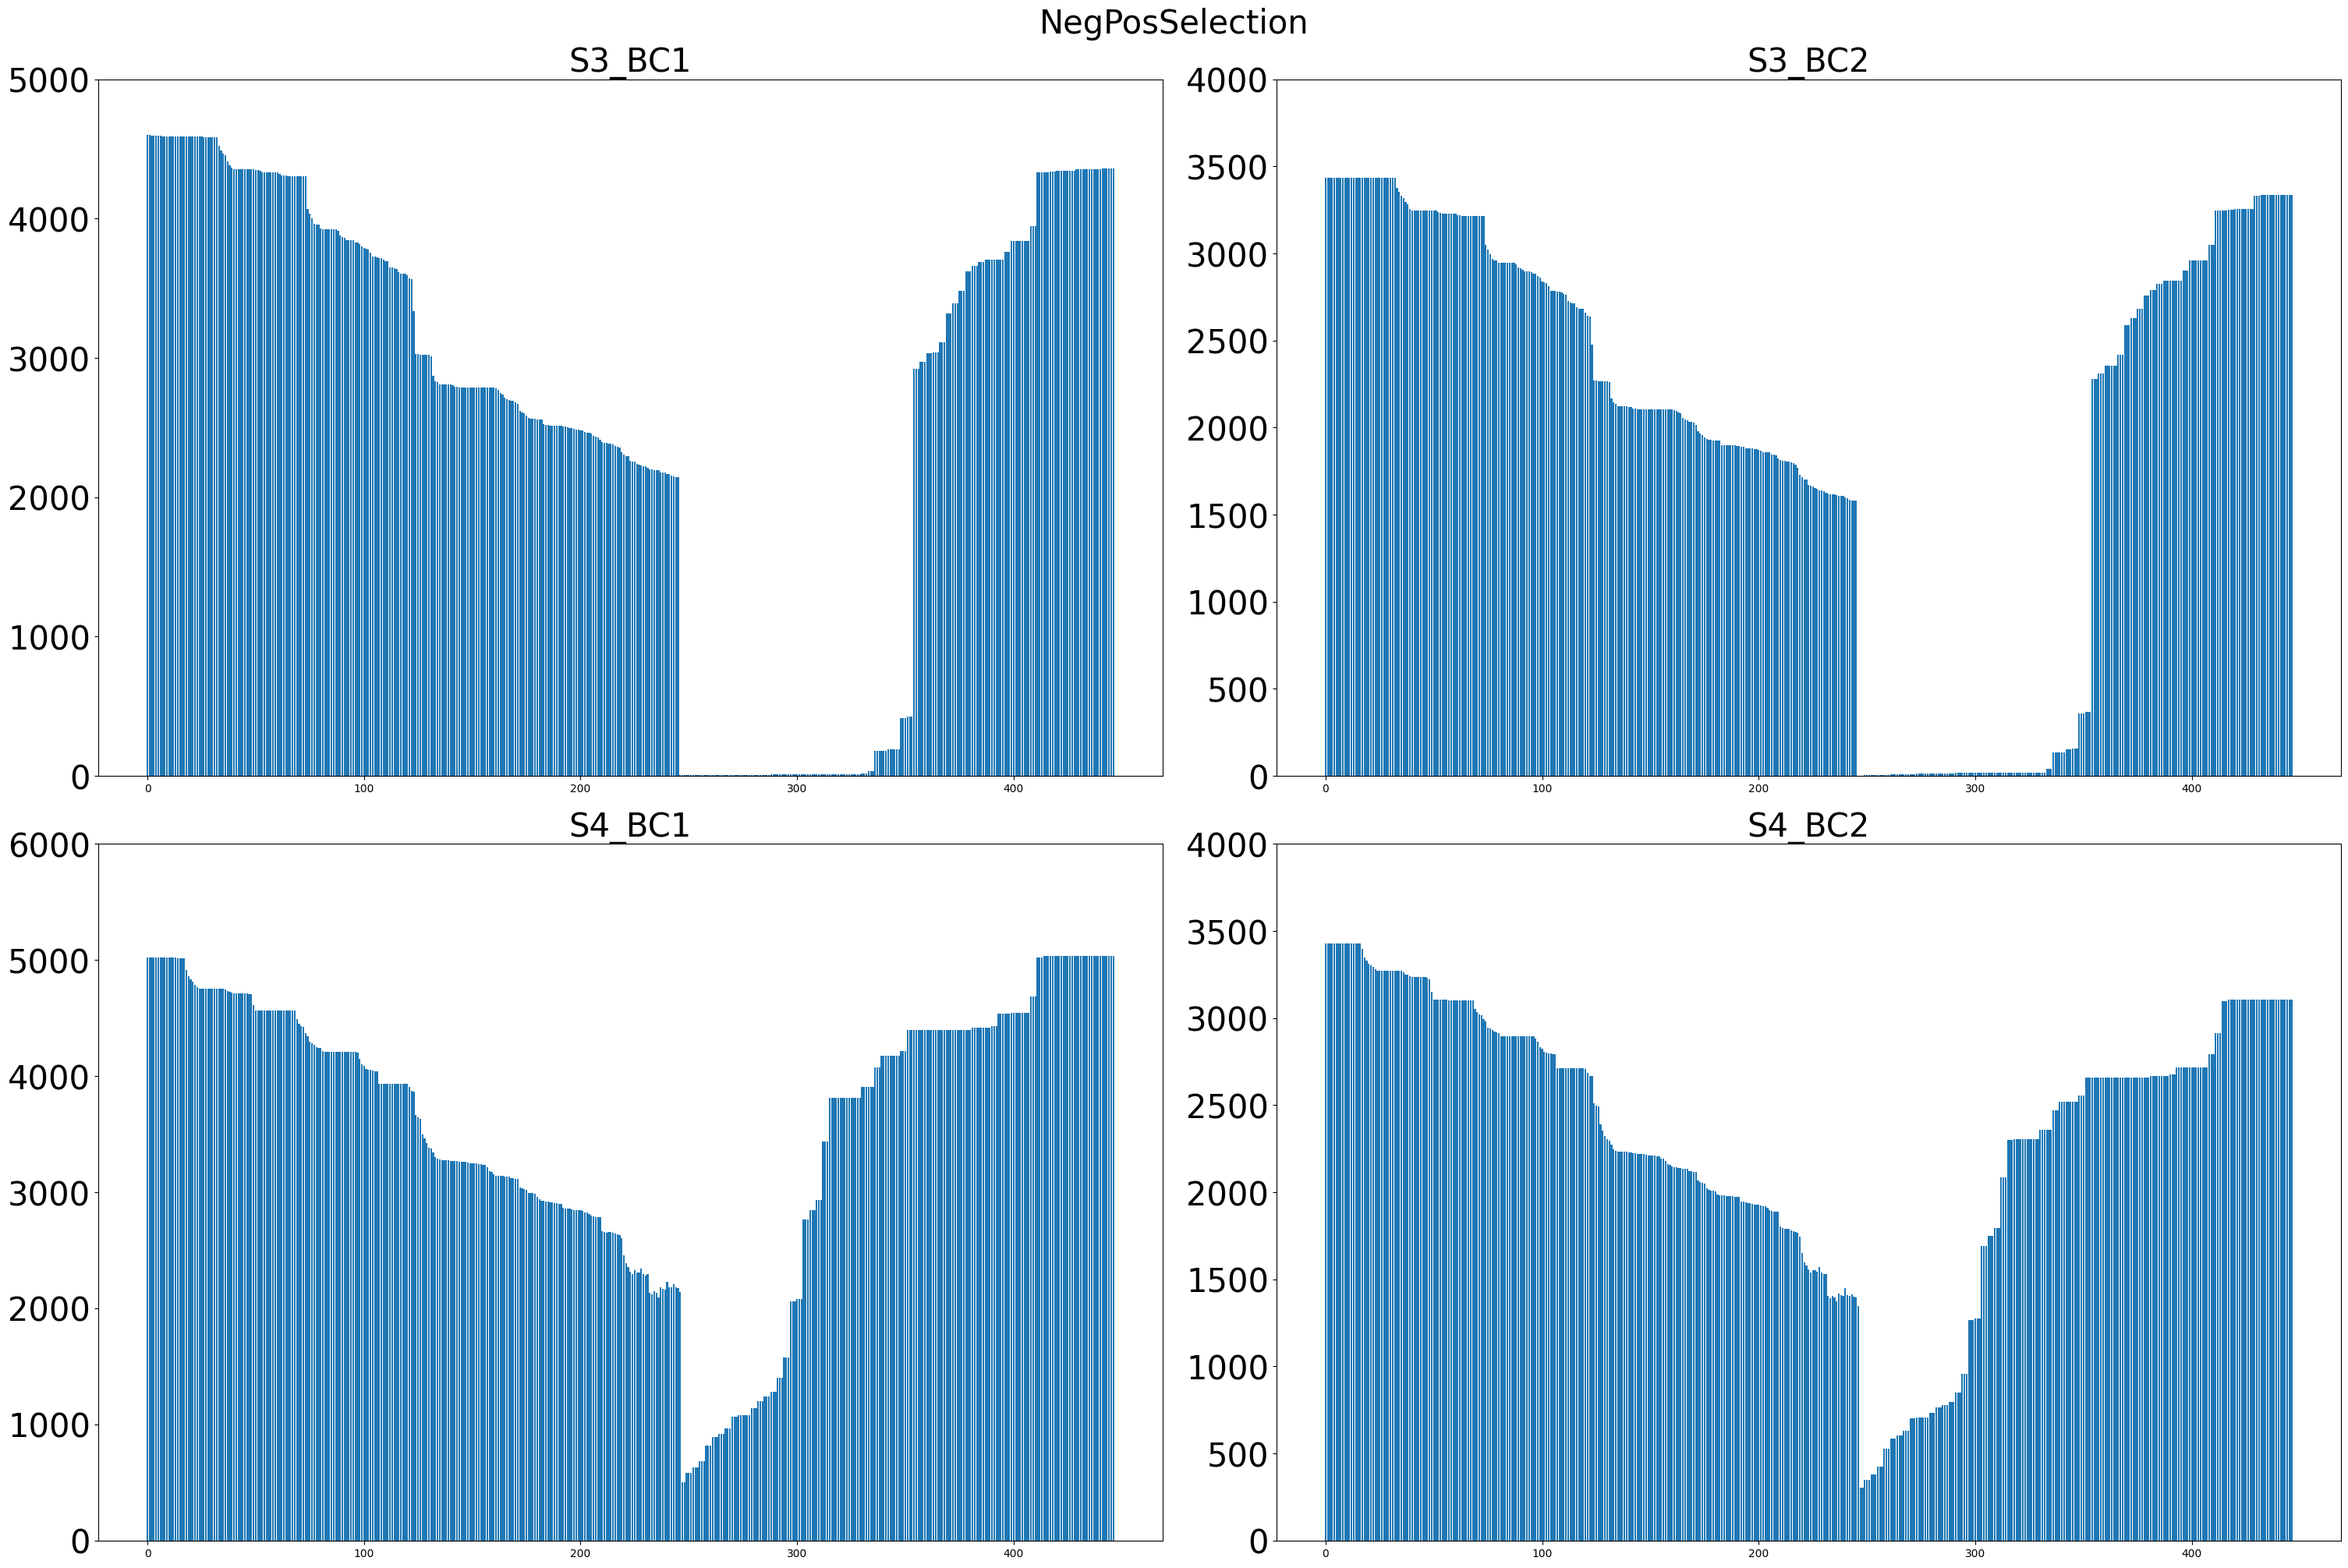

In [213]:
## figure with plots of coverages: 
read_dictionary =Mutagenesis_reads#Mutagenesis_reads#
plt_title = "NegPosSelection"
used_Barcodes = ["BC1", "BC2"]
Sections = ["S3","S4"]

fig, axs = plt.subplots( len(Sections),len(used_Barcodes), figsize=(15*len(used_Barcodes), 10*len(Sections)), layout='constrained')

for Bc in used_Barcodes: 
    for Section in  Sections:
        name = f"{Bc}_{Section}"

        tripl_st = Primer_out_of_triplets[Section+"_fwd"]
        tripl_end = Primer_out_of_triplets[Section+"_rev"]
        ref_section = find_reference_seq(ref_gene=ref_gene, Primer_seq=Primer_seq, Section=Section,Primer_out_of_triplets=Primer_out_of_triplets) 
        
        a_seq = read_dictionary[f"{Bc}_{Section}_R1"]
        b_seq = read_dictionary[f"{Bc}_{Section}_R2"]

        seq_variants = gather_nt_variants(a_seq=a_seq, b_seq = b_seq, catch_left=Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_rev"]+Primer_seq[Section+"_rev"][:tripl_end]), ref=ref_section, use_forward_read=True)

        seq_variants= pd.DataFrame.from_dict(seq_variants).sum()
        

        ax = axs[Sections.index(Section), used_Barcodes.index(Bc)]
        ax.bar(seq_variants.index, seq_variants)
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([int(tick) for tick in ax.get_yticks()], fontsize = 30)
        ax.set_title(f'{Section}_{Bc}', fontsize = 30)
    
fig.suptitle(plt_title, fontsize = 30)      
#plt.savefig(f'/Users/annavonbachmann/Documents/GitHub/DMS_analysis/output/PACE/Mutagenesis_final_DNA_coverage.pdf')                                                            
plt.show()

In [188]:
import functions_
reload(functions_)
from functions_ import *

In [195]:
#### calculate regions of interest i.e. high mut rate and high coverage
high_mut_pos_dict = {"S1":[], "S2":[], "S3":[], "S4":[]}
low_cov_pos_dict = {"S1":[], "S2":[], "S3":[], "S4":[]}

used_Barcodes_perRun = {"Cycle2Mutagenesis": ["BC1"], 
                        "Cycle2NegPos": ["BC1", "BC2"], 
                        "Mutagenesis": ["BC1", "BC2"], 
                        "NegPosSelection": ["BC1", "BC2", "BC3", "BC4"]}

cyclenames = ["Cycle2Mutagenesis", "Cycle2NegPos", "Mutagenesis", "NegPosSelection"]


# used_Barcodes_perRun = {"S2S3alt3cyclesmut": ["BC1", "BC2", "BC3"],
#                          "S2S3alt3cyclesNegPos": ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"],
#                           }


# cyclenames = ["S2S3alt3cyclesmut", "S2S3alt3cyclesNegPos"]


used_Barcodes_perRun = {"MutS2S3_2": ["BC1", "BC2", "BC3"],
                         "NegPosS2S3_2": ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"],
                          }


cyclenames = ['MutS2S3_2', 'NegPosS2S3_2',]


for cyclename in cyclenames:
    used_Barcodes = used_Barcodes_perRun[cyclename]
    for section in Sections:
        for Bc in used_Barcodes:
            high_mut_positions,low_cov_pos = find_mutated_pos(read_dict = all_reads, Bc=Bc, Barcodes=Barcodes, Section=section, ref_gene =ref_gene, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets, data_type = "AA", mut_rate_filter_treshold=0.03,cyclename = cyclename, cov_filter_treshold = 50 ) #####100
            high_mut_pos_dict[section].extend(high_mut_positions)
            low_cov_pos_dict[section].extend(low_cov_pos)

high_mut_pos_dict= {sec: list(set(mut_pos)) for sec, mut_pos in high_mut_pos_dict.items()}


high_mut_pos_dict = {sec:[mut_pos for mut_pos in mut_positions if mut_pos not in low_cov_pos_dict[sec] ] for sec, mut_positions in high_mut_pos_dict.items() }## filter out low coverage positions        

## order dict values
high_mut_pos_dict = {key: [pos for pos in sorted(value)] for key, value in high_mut_pos_dict.items()}

In [177]:
print(high_mut_pos_dict)

{'S1': [96, 139, 145, 147, 148], 'S2': [8, 23, 62, 64, 82, 84, 90, 94, 96, 106, 142, 145], 'S3': [70, 74, 111, 112, 115, 116, 117, 139], 'S4': [47, 48, 49, 78, 79, 80, 81, 98, 106, 116, 146, 147]}


In [ ]:
## calculate position-wise chance of mutation from mutagenic spectrum
# mutagenic spectrum

Sections = ["S1", "S2", "S3", "S4"]# ["S2", "S3"] #
Bc = "BC1"
cycle =  "Mutagenesis" # "S2S3alt3cyclesmut"
use_rev_read = False
ref_gene = R5_Pool_seq

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd"]
    tripl_end = Primer_out_of_triplets[Section+"_rev"]
    ref_seq_Section = find_reference_seq(ref_gene=ref_gene, Primer_seq=Primer_seq, Section=Section,Primer_out_of_triplets=Primer_out_of_triplets)

    a_seq = all_reads[f"{cycle}_{Bc}_{Section}_R1"]
    b_seq = all_reads[f"{cycle}_{Bc}_{Section}_R2"]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, catch_left=Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_rev"]+Primer_seq[Section+"_rev"][:tripl_end]),use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section, set_diag_to_NA = False)

    overall_mut_spectrum += n_mut_spectrum
    combined_ref_sections.append(ref_seq_Section)

print(overall_mut_spectrum)

overall_mut_spectrum_freq = overall_mut_spectrum/overall_mut_spectrum.sum(axis = 1)

chance_of_no_mut = overall_mut_spectrum_freq.max(axis = 1)

chance_of_mut_pos_dict = {}

for Section in Sections: 
    ref_seq_Section = find_reference_seq(ref_gene=ref_gene, Primer_seq=Primer_seq, Section=Section,Primer_out_of_triplets=Primer_out_of_triplets)

    chance_of_no_mut_pos = [chance_of_no_mut[nt] for nt in ref_seq_Section]
    chance_of_mut_codon_pos = [1-(chance_of_no_mut_pos[pos]*chance_of_no_mut_pos[pos+1]*chance_of_no_mut_pos[pos+2]) for pos in range(0, len(chance_of_no_mut_pos), 3)]
    chance_of_mut_pos_dict[Section] = chance_of_mut_codon_pos


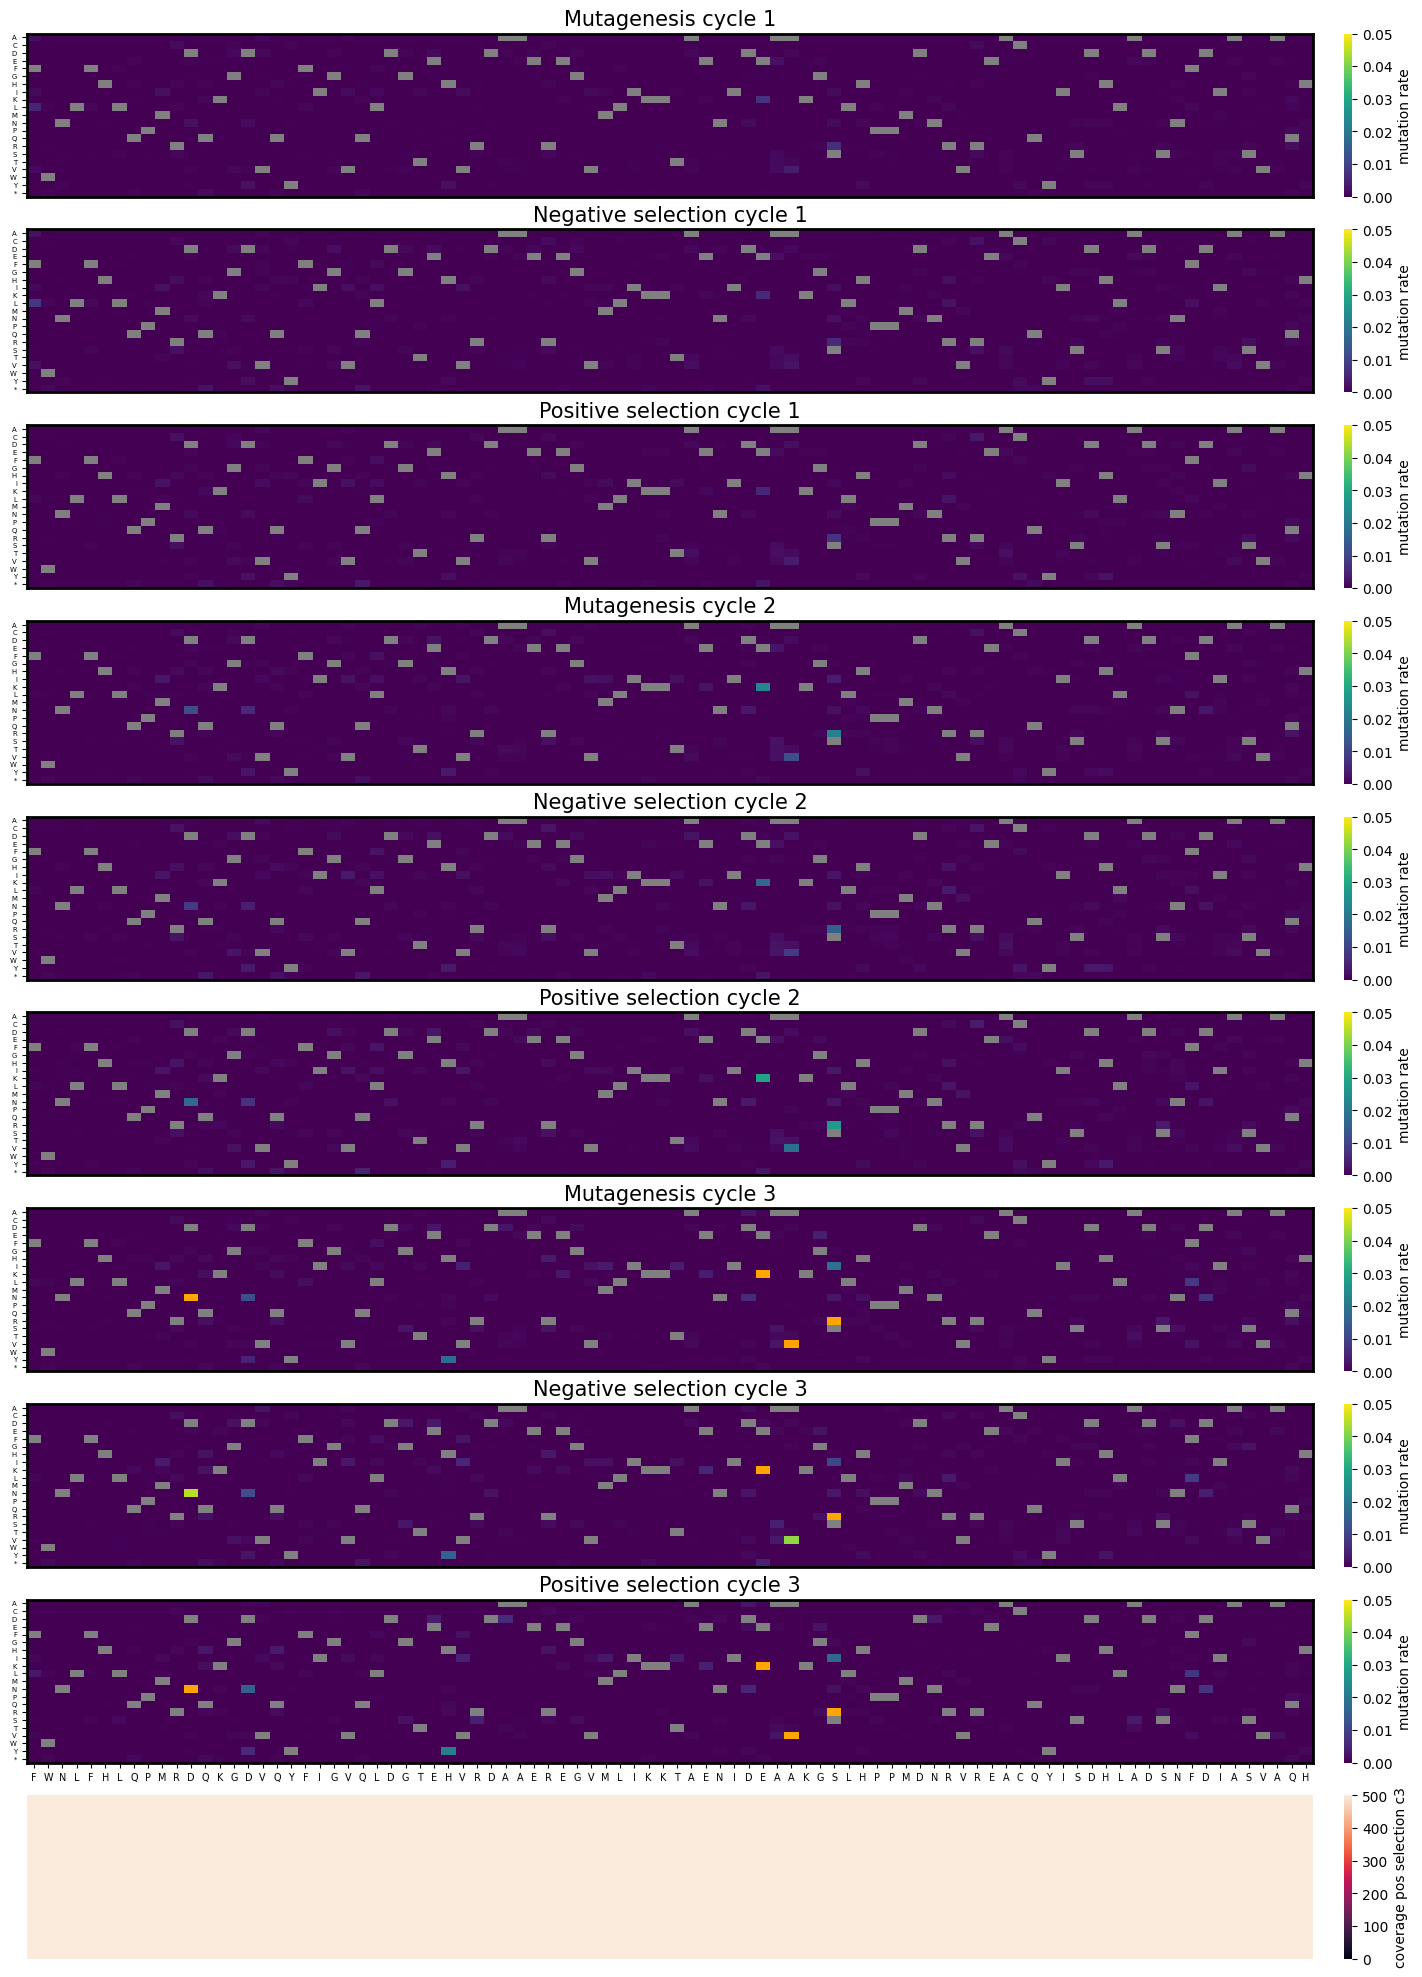

<Figure size 640x480 with 0 Axes>

In [138]:
FigFolder = None 
compare_mut_enrichement(all_reads, "S3", ref_gene, use_rev_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=False, FigFolder=FigFolder, vmax = 0.05, samples = samples, plt_titles=plt_titles,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq)

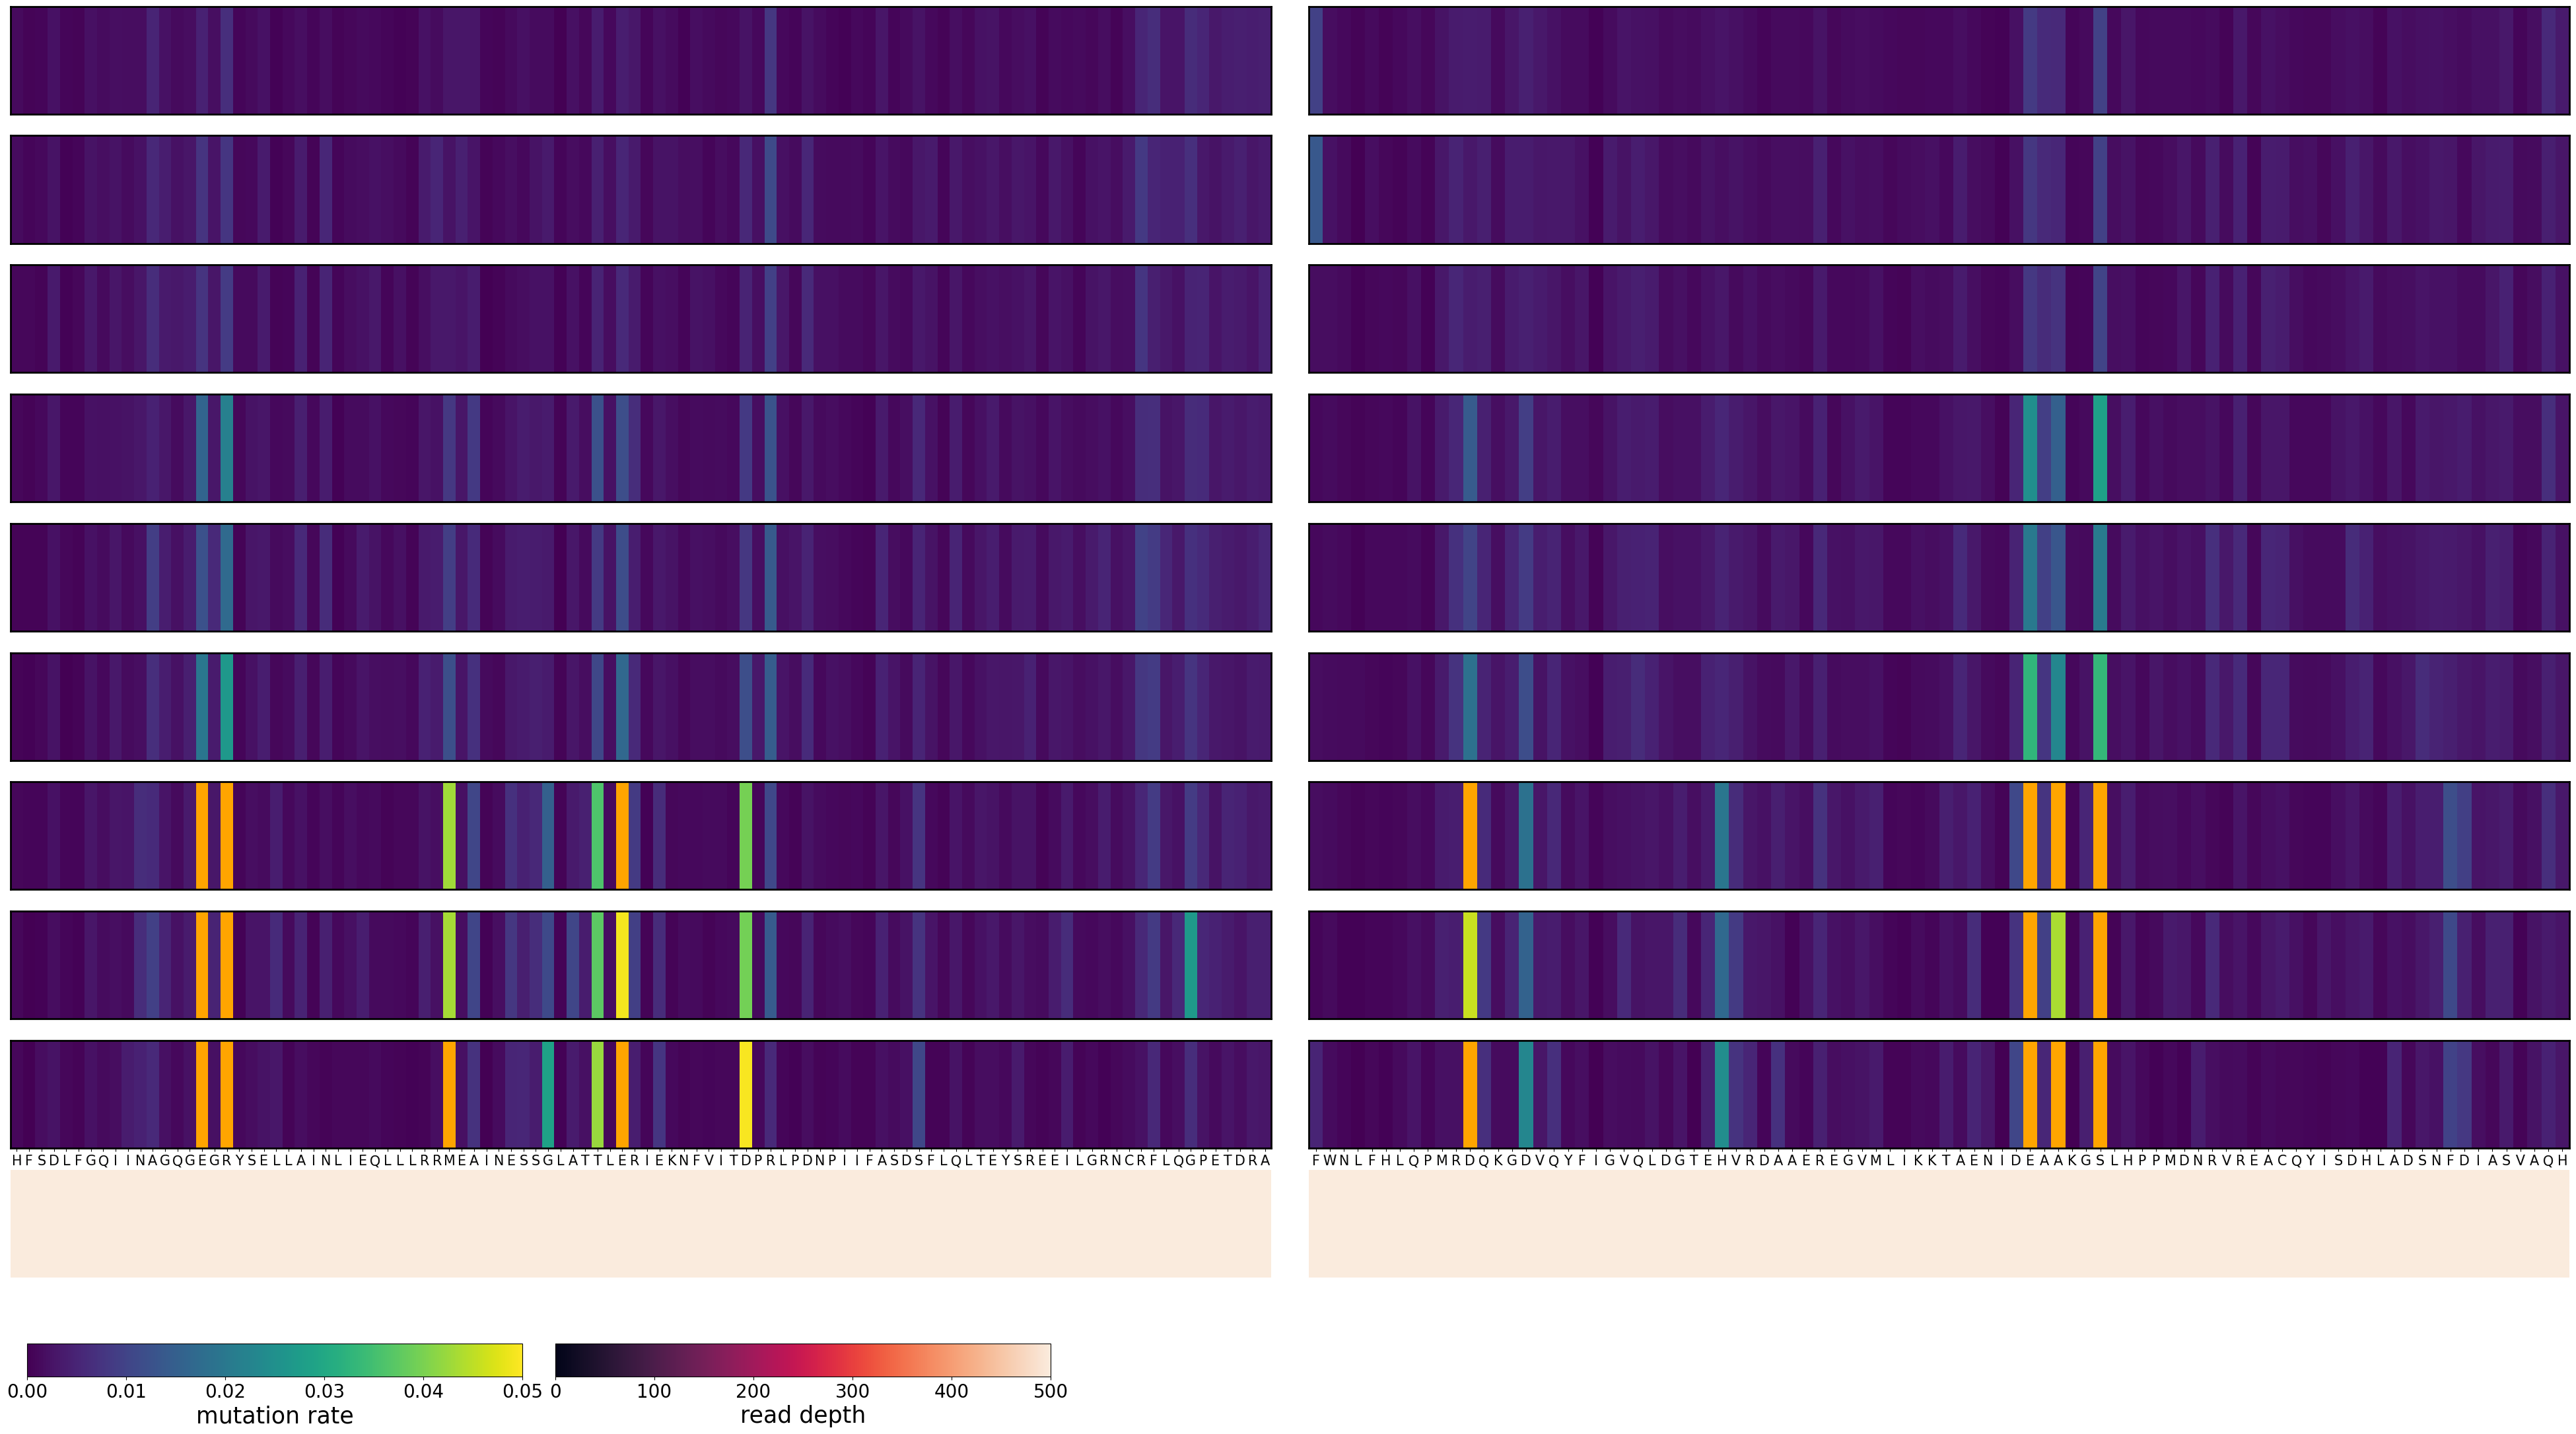

<Figure size 640x480 with 0 Axes>

In [191]:
FigFolder = None#os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
Sections = ["S2", "S3"]
compare_mut_enrichement_for_all(all_reads, ref_gene, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, samples = samples, plt_titles =plt_titles,   Sections = Sections,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.05, show_cbar_for_each = False, show_plttitles = False, bias_per_pos= None)

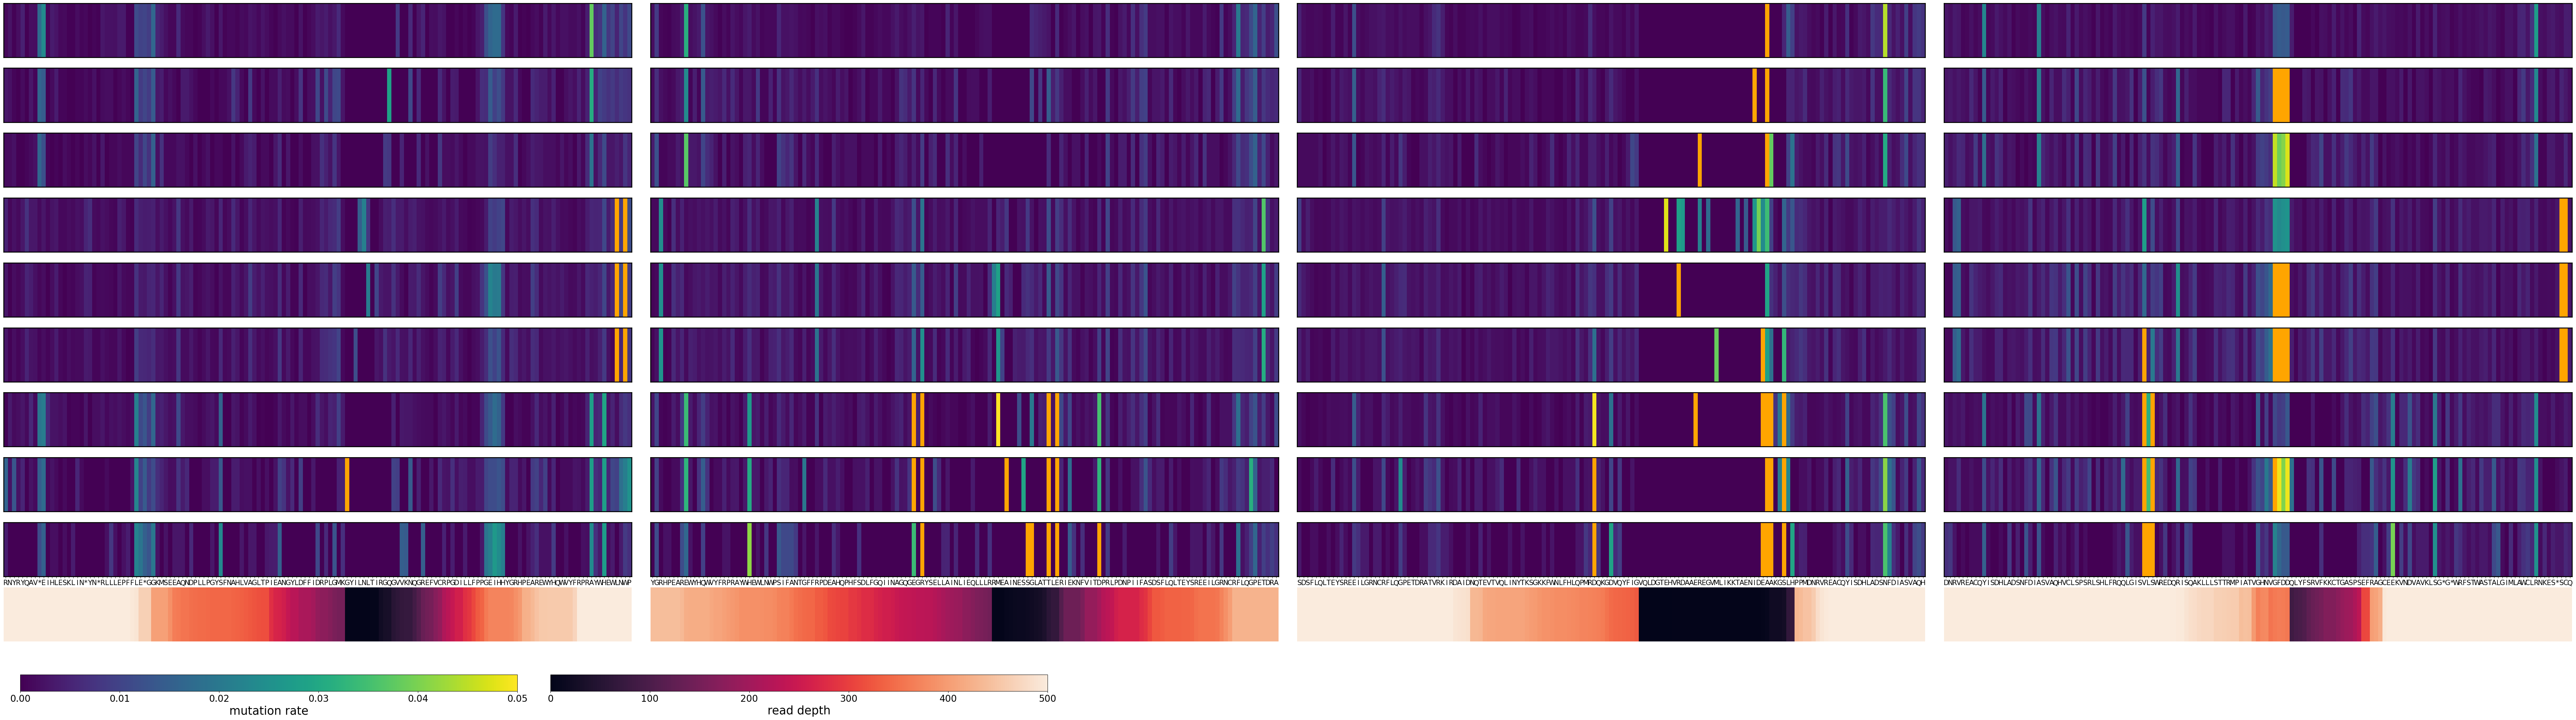

<Figure size 640x480 with 0 Axes>

In [204]:
FigFolder = None#os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
compare_mut_enrichement_for_all(all_reads, ref_gene, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, samples = samples, plt_titles =plt_titles,   Sections = Sections,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.05, show_cbar_for_each = False, show_plttitles = False, bias_per_pos= None)

In [183]:
reload(plotting)
from plotting import *

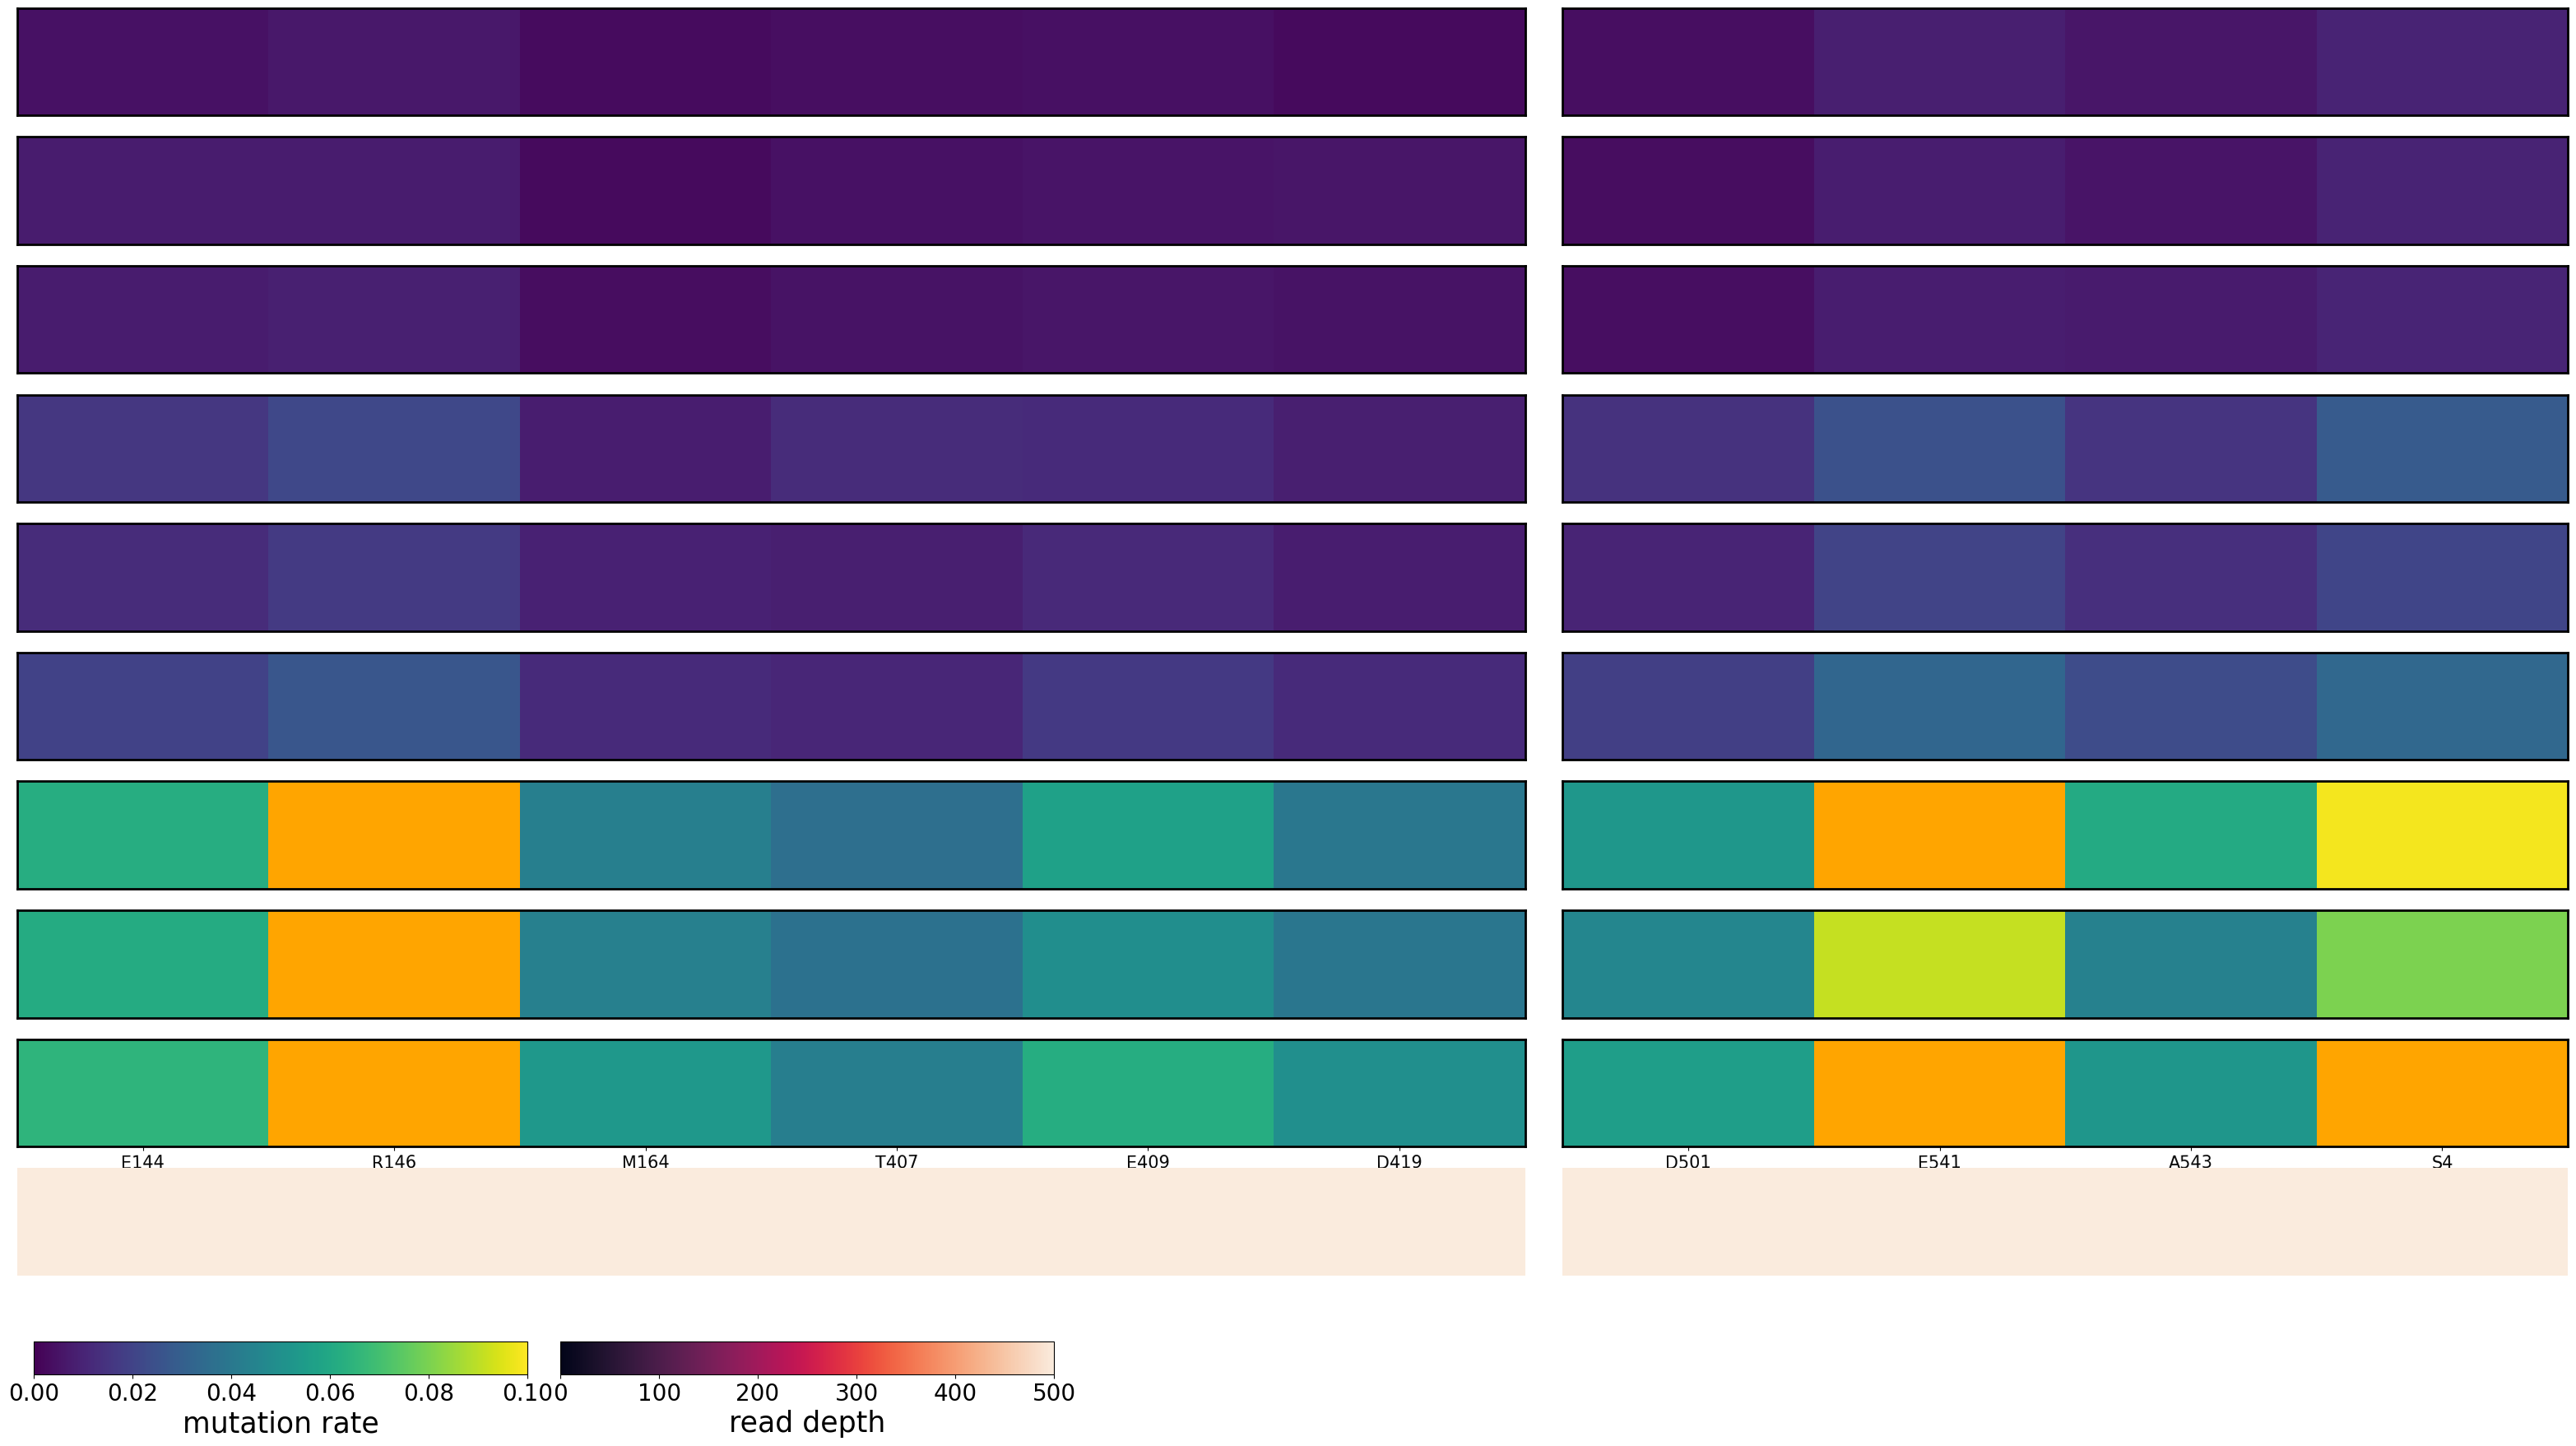

<Figure size 640x480 with 0 Axes>

In [196]:
FigFolder =None# os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
#Sections = ["S2", "S3"]
most_enriched_regions = compare_mut_enrichement_for_all(all_reads, ref_gene,  data_type = "AA", combine_mut_rates=True, Sections = Sections, FigFolder=FigFolder, samples = samples,  plt_titles =plt_titles, Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.1, show_cbar_for_each = False, show_plttitles = False,show_only_pos= high_mut_pos_dict, bias_per_pos= None, AApos_xlabelticks=R5_Pool_AA_annot, return_df = True,  plot_coverage=True)

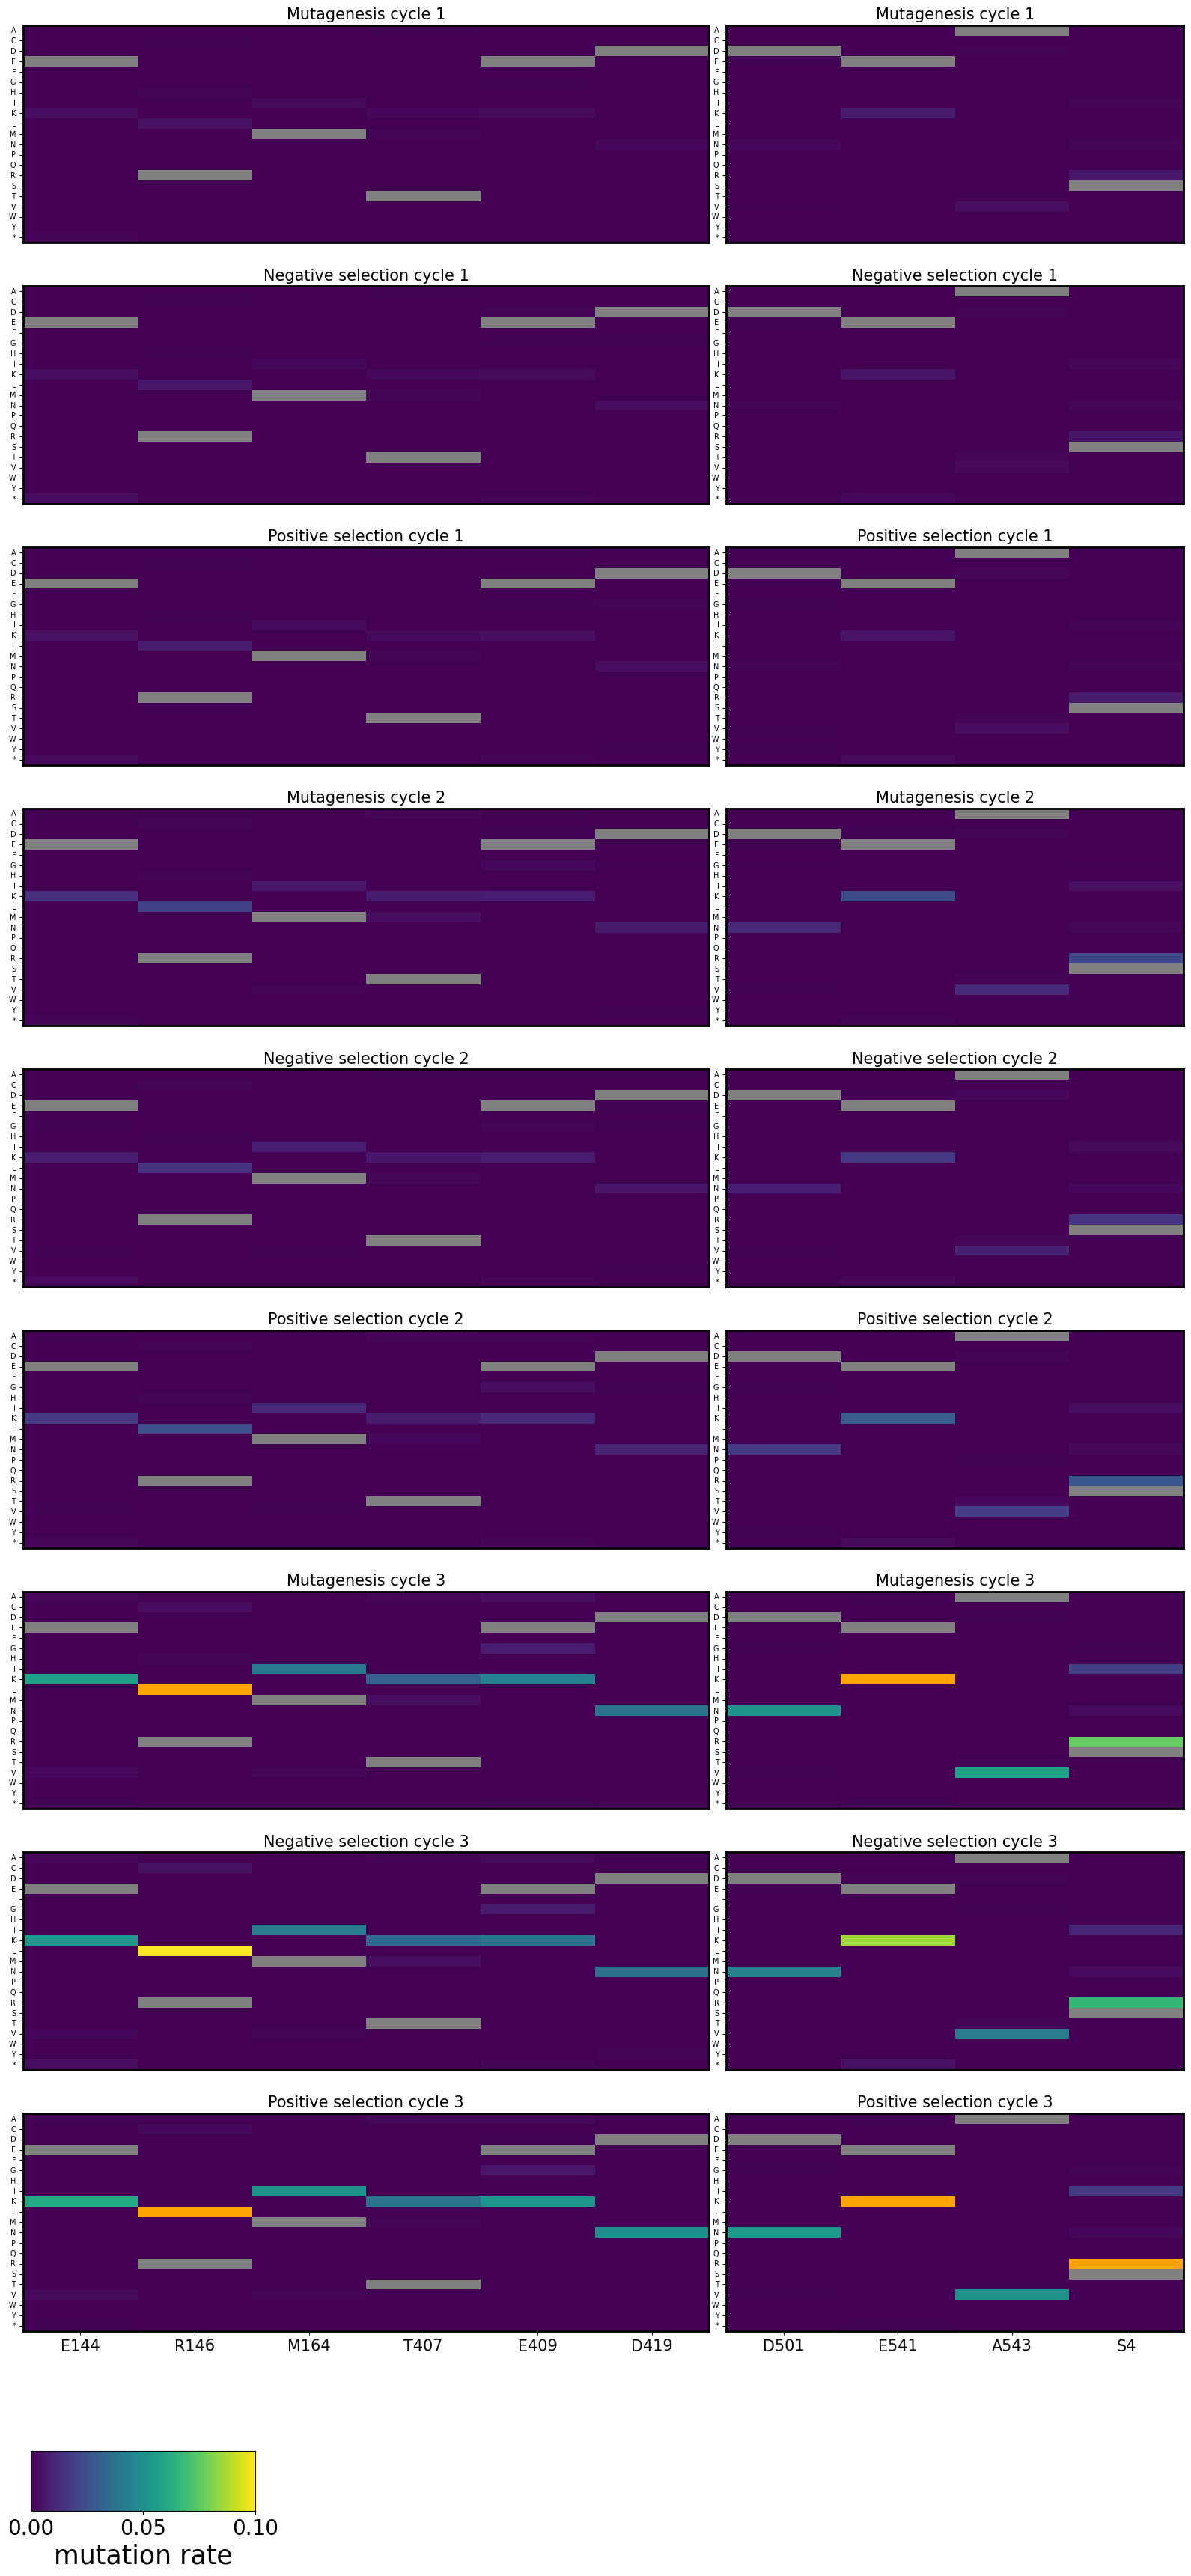

ValueError: Length mismatch: Expected axis has 189 elements, new values have 9 elements

<Figure size 640x480 with 0 Axes>

In [197]:
FigFolder =None# os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
Sections = ["S2", "S3"]
most_enriched_regions = compare_mut_enrichement_for_all(all_reads, ref_gene,  data_type = "AA", combine_mut_rates=False, Sections = Sections, FigFolder=FigFolder, samples = samples,  plt_titles =plt_titles, Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.1, show_cbar_for_each = False, show_plttitles = True,show_only_pos= high_mut_pos_dict, bias_per_pos= None, AApos_xlabelticks=R5_Pool_AA_annot, return_df = True, fig_size = (20, 40), plot_coverage=False)

In [150]:
exclude_pos = ["D501",  "D505", "A542",  "A543", "S4", "L171",  "H172", "N194"]
not_exclude = [pos for pos in most_enriched_regions.columns if pos not in exclude_pos]
#most_enriched_regions.loc[:,  not_exclude].max(axis = 1)
show_pos = ["R146", "M164", "E409", "E541", "S4"] #"G254", "F255", "D257 #"M164", "E541", "S4",

In [202]:
#most_enriched_regions = most_enriched_regions.iloc[[0,2,3,5,6,8],:]

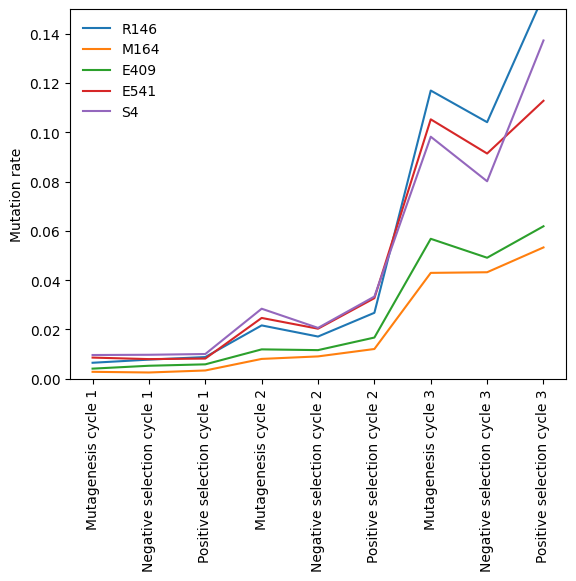

In [151]:
#c= ["lightsteelblue","royalblue",  "mediumblue", "navy", "gold", "sandybrown", "chocolate"]
plt.plot(most_enriched_regions.loc[:,  show_pos])
# for idx, color in enumerate(c): 
#     plt.gca().get_lines()[idx].set_color(color)
plt.xticks( rotation = 90)
plt.ylabel("Mutation rate")
plt.ylim(0,0.15)
plt.legend(labels = show_pos, frameon = False)
#plt.savefig(os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2/mut_enrichment_pattern_line_plot.pdf"))
plt.show()

In [115]:
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC4"
variant = "NegPosSelection"
mut_rates = []
chance_of_muts = []

for Section in Sections:

    tripl_st = Primer_out_of_triplets[Section+"_fwd"]
    tripl_end = Primer_out_of_triplets[Section+"_rev"]
    ref_gene_section = find_reference_seq(ref_gene=ref_gene,Section = Section, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets)
    ref_prot_section = translate_dna2aa(ref_gene_section)

    a_seq = all_reads[ f"{variant}_{Bc}_{Section}_R1"]
    b_seq = all_reads[ f"{variant}_{Bc}_{Section}_R2"]

    seq_variants = gather_codon_variants(a_seq=a_seq, b_seq = b_seq, catch_left=Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_rev"]+Primer_seq[Section+"_rev"][:tripl_end]), ref = ref_gene_section, use_forward_read=True, use_rev_read=False)

    seq_variants = pd.DataFrame.from_dict(seq_variants)

    coverage_df = seq_variants.sum()
    seq_variants = seq_variants.loc[:,coverage_df>0]
    
    _ , mut_rates_section= mask_ref_in_variants_df(variant_df =seq_variants, ref_seq= ref_gene_section, data_type="Codons")
    mut_rates.extend(mut_rates_section.sum())
    chance_of_muts.extend(chance_of_mut_pos_dict[Section][:len(mut_rates_section.sum())])

Text(0, 0.5, 'Chance of codon mutation')

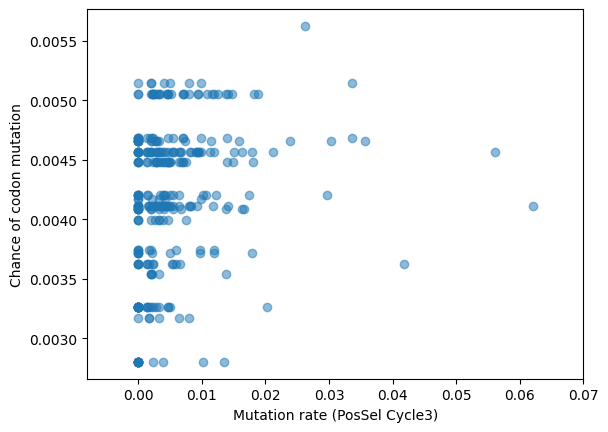

In [116]:
plt.scatter(mut_rates, chance_of_muts, alpha=0.5)
plt.xlim(-0.008, 0.07)
plt.xlabel( "Mutation rate (PosSel Cycle3)" )
plt.ylabel( "Chance of codon mutation")#

In [50]:

import scipy.stats
scipy.stats.spearmanr(mut_rates, chance_of_muts)

SignificanceResult(statistic=np.float64(0.3160812986490244), pvalue=np.float64(5.666060607548022e-09))

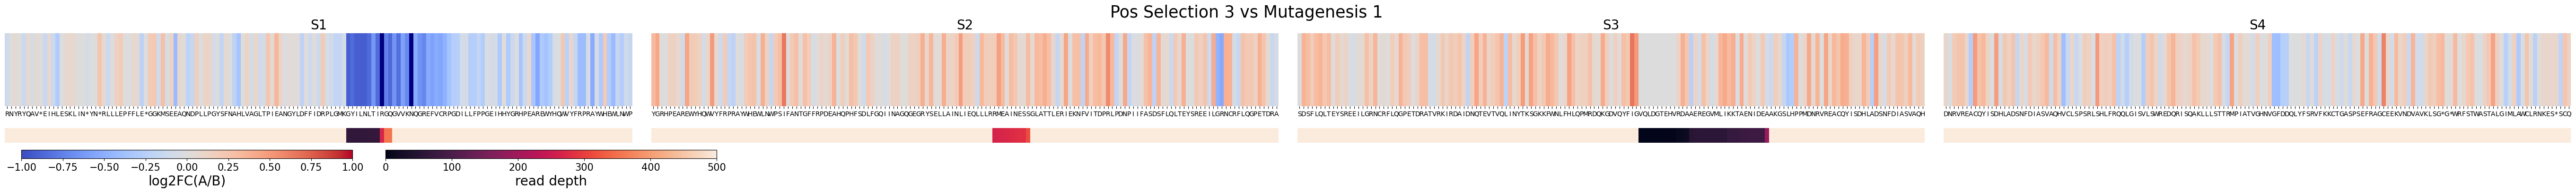

In [60]:
#figfolder = "output/PACE/cycle_mut_enrichment"
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC2"
CylceB = "NegPosSelection" #"Mutagenesis"
BarcodeB = "BC1"
Sections = ["S1", "S2", "S3", "S4"]
name = "Pos Selection 3 vs Mutagenesis 1"
combine_mut_rates=True
vmax = 1
show_cbar_for_each = False
cbar_label = "log2FC(A/B)"

fig = plt.figure(figsize=(70, 3))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 0.2], width_ratios=[1, 1, 1, 1])

axes = []
for i in range(2):
    row_axes = []
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

fig.suptitle(name, fontsize = 25, y=1.08)

fig.subplots_adjust(wspace=0.03, hspace=0.5)

for idx, Section in enumerate(Sections): 
    stepA = f"{CycleA}_{BarcodeA}_{Section}"
    stepB = f"{CylceB}_{BarcodeB}_{Section}"

    FC_variants, ref, coverage_A, coverage_B = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA", combine_mut_rates=combine_mut_rates)

    my_cmap = plt.get_cmap('coolwarm').copy()
    my_cmap.set_over('saddlebrown')
    my_cmap.set_under('navy')


    #plot_mutation_enrichment(FC_variants,  name = f"{stepA} vs {stepB}", ref_seq=ref, data_type = "AA", fig_folder= None, cmap = "coolwarm", cbar_label=f"log2FC({stepA}/{stepB})", vmax = 0.05)  
    sns.heatmap(pd.DataFrame(FC_variants).T ,cmap = my_cmap, xticklabels=ref, yticklabels=not combine_mut_rates, center = 0, ax = axes[0][idx], cbar = show_cbar_for_each, vmax = vmax, vmin = -vmax if vmax else None ,square = not combine_mut_rates)
    axes[0][idx].set_title(Section, fontsize = 20)
    axes[0][idx].set_xticklabels(axes[0][idx].get_xticklabels(), rotation=1, fontsize=10)
    sns.heatmap(pd.DataFrame(coverage_A).T, linecolor="black", xticklabels=False, yticklabels=False, ax = axes[1][idx], cbar = show_cbar_for_each, vmax = 500, vmin = 0)

if not show_cbar_for_each:
    ## add at the bottom of the figure horizontally a cbar for the relative counts
    cbar_ax = fig.add_axes([0.13, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[0][0].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(axes[0,0].collections[0], cax=cbar_ax)
    # cbar.set_label('relative counts', fontsize = 20)
    # cbar.ax.tick_params(labelsize=15)

    # ## ad cbar also for coverage
    cbar_ax = fig.add_axes([0.24, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[1][3].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label('read depth', fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

#plt.savefig(figfolder + f'/{name.replace(" ", "_")}_log2FC.pdf', bbox_inches="tight")

plt.show()
plt.close()

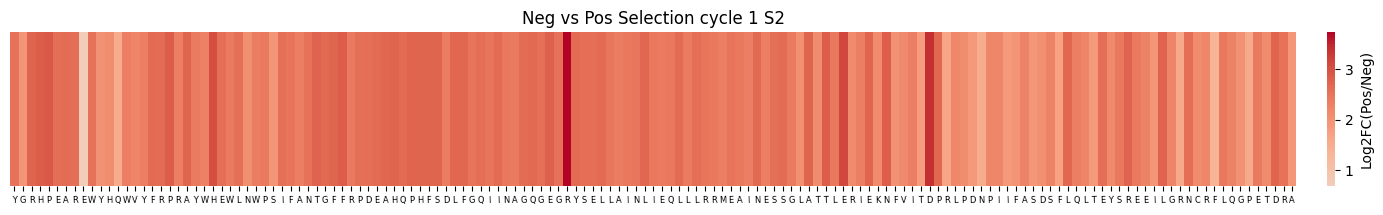

In [53]:
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC4"
CylceB = "Mutagenesis"
BarcodeB = "BC1"
Section = "S2"

stepA = f"{CycleA}_{BarcodeA}_{Section}"
stepB = f"{CylceB}_{BarcodeB}_{Section}"



FC_variants, ref, _,_ = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA",combine_mut_rates=True)

name = "Neg vs Pos Selection cycle 1 "+ Section
plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(FC_variants).T, cmap = "coolwarm", cbar_kws = {"pad": 0.02, "label": "Log2FC(Pos/Neg)" },linecolor="black", xticklabels=ref, yticklabels=False, center = 0)
plt.xticks(rotation = 2,fontsize=6)
plt.title(name)
plt.show()


In [187]:
# mutagenic spectrum codons
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC4"
cycle = "NegPosSelection"
use_rev_read = False

combined_ref_sections = []


for idx, Section in enumerate(Sections): 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]

    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum_codons(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left="",catch_right="",use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)
    

    if idx == 0:
        overall_mut_spectrum = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    else: 
        overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")

    combined_ref_sections.append(ref_seq_Section)

combined_ref_sections = "".join(combined_ref_sections)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100

ref_codons = [combined_ref_sections[i:i+3] for i in range(0, len(combined_ref_sections), 3)]
# np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
# np.fill_diagonal(overall_mut_spectrum.values, np.nan)


KeyError: 'S1_fwd_primer'

In [194]:
overall_mut_spectrum_perc = overall_mut_spectrum_perc.loc[[codon for codon in codons if codon in ref_codons],:]

In [401]:
AAs = list(set(genetic_code.values()))
AA_codons = {Aa: [codon for codon, aa in genetic_code.items() if aa == Aa] for Aa in AAs}

AA_cod_mut_spectrum = pd.DataFrame(index=AAs, columns=codons, data = 0.0)

for aa in AAs:
    aa_cod = AA_codons[aa]
    for cod in aa_cod:
        AA_cod_mut_spectrum.loc[aa,:] += overall_mut_spectrum_perc.loc[cod,:]

AA_mut_spectrum = pd.DataFrame(index=AAs, columns=AAs, data = 0.0)
for aa in AAs: 
    aa_cod = AA_codons[aa]
    for cod in aa_cod:
        AA_mut_spectrum.loc[:,aa] += AA_cod_mut_spectrum.loc[:,cod]

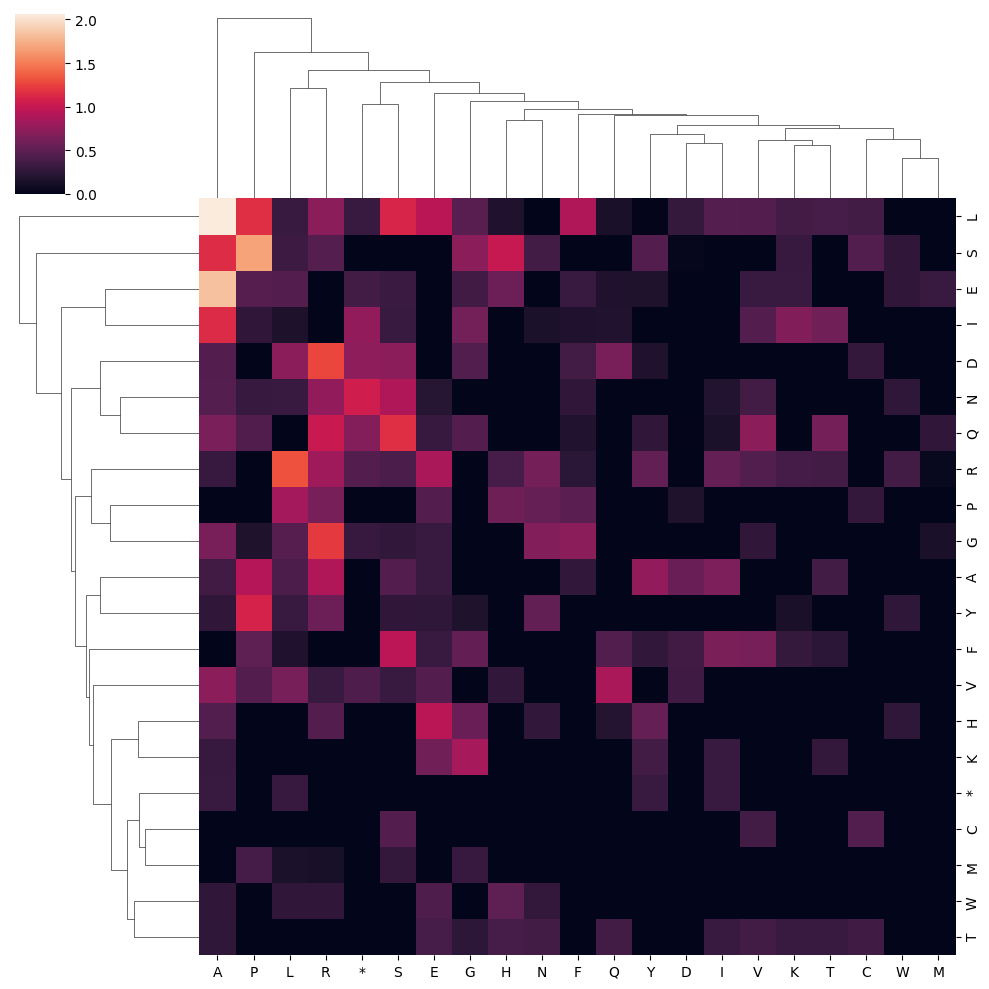

In [402]:
sns.clustermap(AA_mut_spectrum)

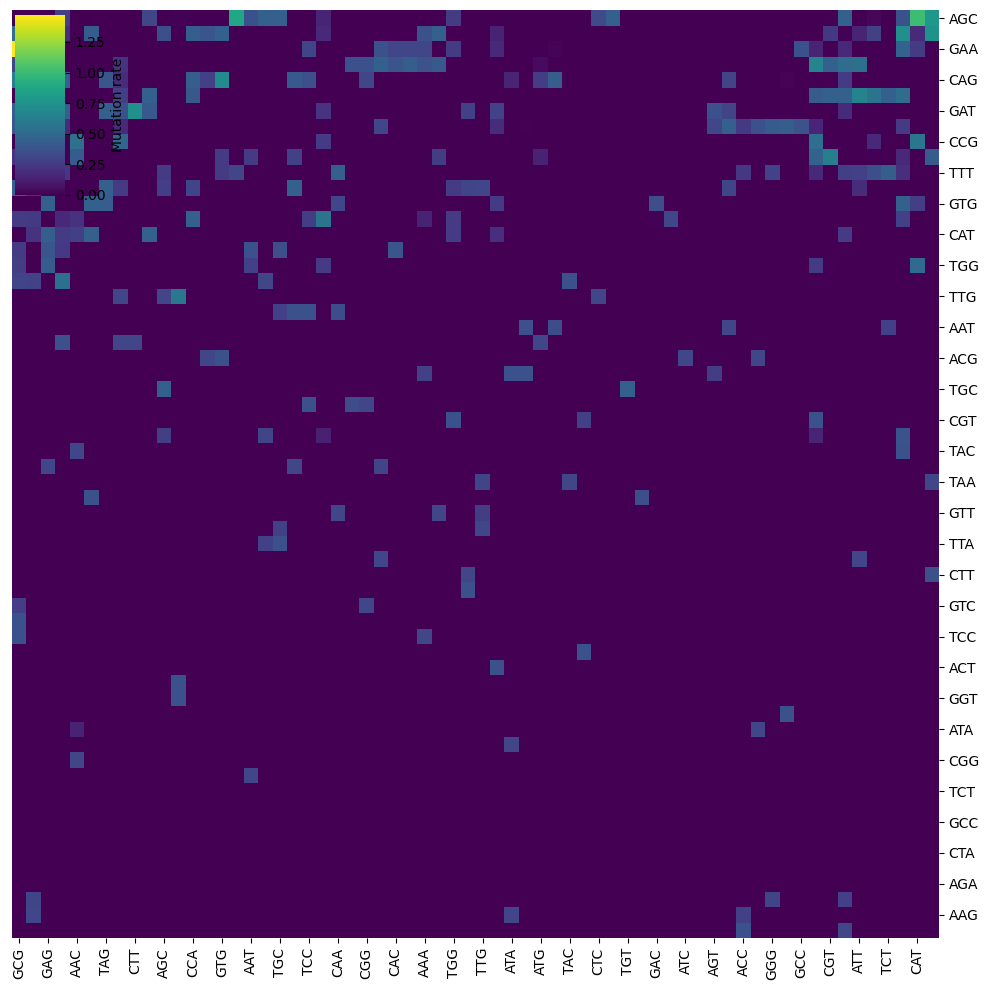

In [195]:
sns.clustermap(overall_mut_spectrum_perc, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", dendrogram_ratio=(.00001, .00001))

In [149]:
overall_mut_spectrum

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATC,0.0,NaN,0.0,0.0,0.0,0.0,591.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATT,0.0,1.0,NaN,1.0,1.0,407.0,2.0,1.0,2.0,4.0,...,1.0,2.0,5.0,1.0,509.0,1.0,0.0,0.0,740.0,1.0
ATG,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ACA,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
TGC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,738.0,0.0,0.0
TGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
TGA,513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [181]:
all_reads.keys()

dict_keys(['S2S3alt3cyclesmut_BC1_S2_R1', 'S2S3alt3cyclesmut_BC1_S2_R2', 'S2S3alt3cyclesmut_BC1_S3_R1', 'S2S3alt3cyclesmut_BC1_S3_R2', 'S2S3alt3cyclesmut_BC2_S2_R1', 'S2S3alt3cyclesmut_BC2_S2_R2', 'S2S3alt3cyclesmut_BC2_S3_R1', 'S2S3alt3cyclesmut_BC2_S3_R2', 'S2S3alt3cyclesmut_BC3_S2_R1', 'S2S3alt3cyclesmut_BC3_S2_R2', 'S2S3alt3cyclesmut_BC3_S3_R1', 'S2S3alt3cyclesmut_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC1_S2_R1', 'S2S3alt3cyclesNegPos_BC1_S2_R2', 'S2S3alt3cyclesNegPos_BC1_S3_R1', 'S2S3alt3cyclesNegPos_BC1_S3_R2', 'S2S3alt3cyclesNegPos_BC2_S2_R1', 'S2S3alt3cyclesNegPos_BC2_S2_R2', 'S2S3alt3cyclesNegPos_BC2_S3_R1', 'S2S3alt3cyclesNegPos_BC2_S3_R2', 'S2S3alt3cyclesNegPos_BC3_S2_R1', 'S2S3alt3cyclesNegPos_BC3_S2_R2', 'S2S3alt3cyclesNegPos_BC3_S3_R1', 'S2S3alt3cyclesNegPos_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC4_S2_R1', 'S2S3alt3cyclesNegPos_BC4_S2_R2', 'S2S3alt3cyclesNegPos_BC4_S3_R1', 'S2S3alt3cyclesNegPos_BC4_S3_R2', 'S2S3alt3cyclesNegPos_BC5_S2_R1', 'S2S3alt3cyclesNegPos_BC5_S2_R2', 'S2S3

In [193]:
# mutagenic spectrum
Sections = [ "S2", "S3"]
Bc = "BC1"
cycle = "S2S3alt3cyclesmut"
use_rev_read = True

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]),use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)

    print(pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float"))

    overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    combined_ref_sections.append(ref_seq_Section)

chance_of_mutation_df = overall_mut_spectrum/overall_mut_spectrum.sum(axis = 1)
np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(overall_mut_spectrum.values, np.nan)

print(overall_mut_spectrum)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100



print(overall_mut_spectrum_perc)
print(chance_of_mutation_df)


          A         C         G         T
A  393682.0     224.0     324.0     183.0
C     607.0  413666.0      67.0     641.0
G     673.0      60.0  341847.0     523.0
T     178.0     235.0     331.0  366884.0
          A         C         G         T
A  364917.0    1039.0    2233.0     461.0
C    5712.0  360747.0     507.0    1145.0
G    2151.0     616.0  476528.0     876.0
T     354.0     330.0    1203.0  303707.0
        A       C       G       T
A     NaN  1263.0  2557.0   644.0
C  6319.0     NaN   574.0  1786.0
G  2824.0   676.0     NaN  1399.0
T   532.0   565.0  1534.0     NaN
           A         C          G         T
A        NaN  6.109418  12.368790  3.115174
C  30.566439       NaN   2.776568  8.639288
G  13.660330  3.269966        NaN  6.767281
T   2.573405  2.733033   7.420307       NaN
          A         C         G         T
A  0.994150  0.001613  0.003106  0.000957
C  0.008281  0.988917  0.000697  0.002653
G  0.003701  0.000863  0.994049  0.002078
T  0.000697  0.000721 

In [ ]:
## expected mut spectrum
combined_ref_sections = "".join(combined_ref_sections)
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_nt in combined_ref_sections:
    for mut_nt in ["A", "C", "G", "T"]:
        if ref_nt != mut_nt:
        ## calculate mutagenic spectrum for all expected changes per Nt
            mut_spec_expected[ref_nt][mut_nt] += 1

mut_spec_expected = pd.DataFrame.from_dict(mut_spec_expected, orient='index', dtype = "float")
mut_spec_expected_perc = mut_spec_expected/mut_spec_expected.sum().sum()*100

plot_mutation_spectrum(mut_spec_expected_perc, samplename = "Mutagenesis", fig_folder = None, colormap = "viridis")

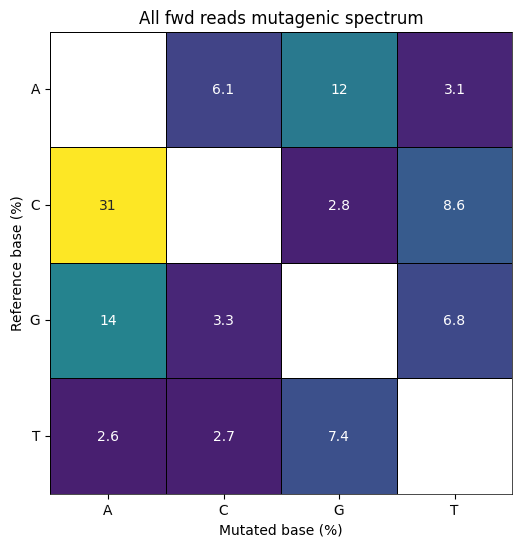

<Figure size 640x480 with 0 Axes>

In [188]:
plot_mutation_spectrum(overall_mut_spectrum_perc,samplename = "All fwd reads",  fig_folder = "output/PACE/repS2S3/")

In [86]:
all_reads.keys()

dict_keys(['S2S3alt3cyclesmut_BC1_S2_R1', 'S2S3alt3cyclesmut_BC1_S2_R2', 'S2S3alt3cyclesmut_BC1_S3_R1', 'S2S3alt3cyclesmut_BC1_S3_R2', 'S2S3alt3cyclesmut_BC2_S2_R1', 'S2S3alt3cyclesmut_BC2_S2_R2', 'S2S3alt3cyclesmut_BC2_S3_R1', 'S2S3alt3cyclesmut_BC2_S3_R2', 'S2S3alt3cyclesmut_BC3_S2_R1', 'S2S3alt3cyclesmut_BC3_S2_R2', 'S2S3alt3cyclesmut_BC3_S3_R1', 'S2S3alt3cyclesmut_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC1_S2_R1', 'S2S3alt3cyclesNegPos_BC1_S2_R2', 'S2S3alt3cyclesNegPos_BC1_S3_R1', 'S2S3alt3cyclesNegPos_BC1_S3_R2', 'S2S3alt3cyclesNegPos_BC2_S2_R1', 'S2S3alt3cyclesNegPos_BC2_S2_R2', 'S2S3alt3cyclesNegPos_BC2_S3_R1', 'S2S3alt3cyclesNegPos_BC2_S3_R2', 'S2S3alt3cyclesNegPos_BC3_S2_R1', 'S2S3alt3cyclesNegPos_BC3_S2_R2', 'S2S3alt3cyclesNegPos_BC3_S3_R1', 'S2S3alt3cyclesNegPos_BC3_S3_R2', 'S2S3alt3cyclesNegPos_BC4_S2_R1', 'S2S3alt3cyclesNegPos_BC4_S2_R2', 'S2S3alt3cyclesNegPos_BC4_S3_R1', 'S2S3alt3cyclesNegPos_BC4_S3_R2', 'S2S3alt3cyclesNegPos_BC5_S2_R1', 'S2S3alt3cyclesNegPos_BC5_S2_R2', 'S2S3

In [158]:
## Look for coocurrence of mutations in the same read (choose positive selection cylce 3)
## specifically E144K and R146L mutations
## is in Section 2
Section = "S2" 
Bc = "BC6"
read_of_interest = all_reads[f"NegPosS2S3_2_{Bc}_{Section}_R1"] #all_reads[f"S2S3alt3cyclesNegPos_{Bc}_{Section}_R1"]#[f"NegPosSelection_{Bc}_{Section}_R1"] ## fwd read section 2 pos selection cycle 3
region = "ISVLS" 
region = "QGEGR"

## find the positions of the mutations

tripl_st = Primer_out_of_triplets[Section+"_fwd"]
ref_gene_section = find_reference_seq(ref_gene = R5_Pool_seq, Primer_seq = Primer_seq, Section = Section, Primer_out_of_triplets = Primer_out_of_triplets)
ref_protein_section = translate_dna2aa(ref_gene_section)

catch_left = Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st]
AA_seqs = [translate_dna2aa(dna[dna.index(catch_left)+len(catch_left):]) for dna in read_of_interest if catch_left in dna]

index_of_interest = ref_protein_section.index(region)
sections_of_interest = [AA_seq[index_of_interest:index_of_interest+len(region)] for AA_seq in AA_seqs] 
sections_of_interest = [sec for sec in sections_of_interest if len(sec)==len(region)]## keep only those that have the region of interest

## find occurences of mutations
coocurrence = {}
for sec in sections_of_interest:
    if sec[2:] not in coocurrence:
        coocurrence[sec[2:]] = 1
    else: 
        coocurrence[sec[2:]] += 1

## order coocurrence after value size
coocurrence = dict(sorted(coocurrence.items(), key=lambda item: item[1], reverse=True))
## filter for coocurrence > 1 (exclude seq errors)
coocurrence = {key: value for key, value in coocurrence.items() if value > 5}

In [159]:
coocurrence

{'EGR': 6061,
 'EGL': 1078,
 'KGR': 377,
 'KGL': 89,
 'VGR': 20,
 'EGC': 13,
 'ESR': 8,
 'AGR': 7}

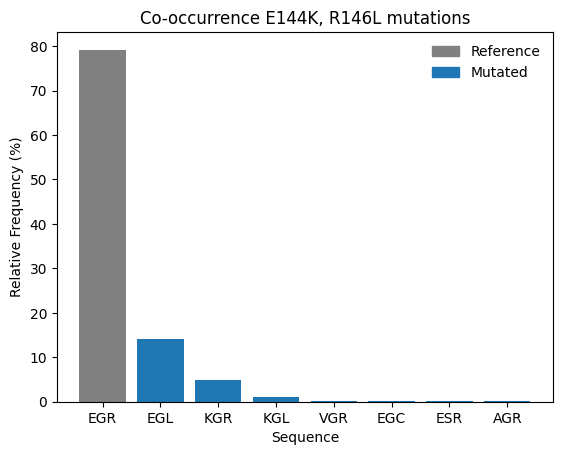

In [160]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey
plt.title("Co-occurrence E144K, R146L mutations")#V223M, L224M, S225R mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
#plt.savefig("output/PACE/mutation_cooccurrence/Cooccurence_E144K_R146L_repSeqS2.pdf")

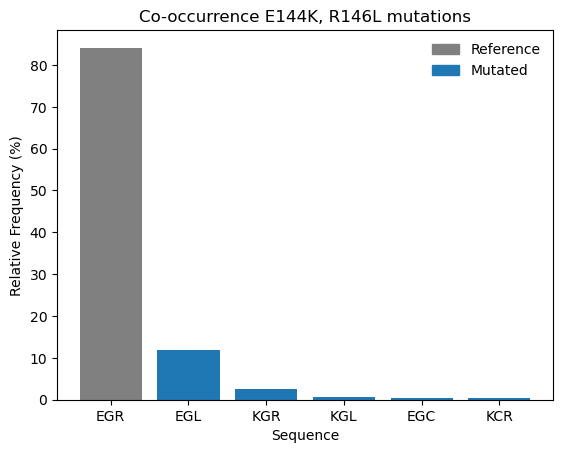

In [36]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey

plt.title("Co-occurrence E144K, R146L mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
plt.savefig("output/PACE/mutation_cooccurrence/Cooocurrence_E144K_R146L.pdf")